# fea try
* do the hw1 from the fea course I took a while ago
* but try it in julia

In [300]:
using Plots


In [301]:

g1 = 0
g2 = 0.001

u_0 = g1
u_l = g2

f_bar =10e11

function f(x)
   return x*f_bar 
end
num_elm = 100
num_nodes = num_elm+1
h = 10e6
L = 0.1
dofs_per_elem = 2
# dofs_per_elem_values = collect(1:dofs_per_elem)
quad_rule = 2
quad_rule_values = collect(1:quad_rule)
basisFunctionOrder  = 1
area = 10e-4
modulus = 10e11

struct  Quad
   quad_points # = [-sqrt(1/3), sqrt(1/3)],
   quad_weights# = [1, 1]
    
end



In [302]:
quad_rule_values

2-element Array{Int64,1}:
 1
 2

In [303]:
points = [-sqrt(1/3), sqrt(1/3)]
weights = [1,1]
myquad =  Quad(points, weights)

Quad([-0.57735, 0.57735], [1, 1])

In [304]:

# step = L/num_elm
node_loc =  collect(range(0, length=num_nodes, stop=L))

101-element Array{Float64,1}:
 0.0  
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009
 0.01 
 0.011
 0.012
 ⋮    
 0.089
 0.09 
 0.091
 0.092
 0.093
 0.094
 0.095
 0.096
 0.097
 0.098
 0.099
 0.1  

In [305]:
elem_node_map  = zeros(Int8,num_elm,2); # Array{Float64, 2}(undef, 2, 3)


In [306]:
# elem_node_map  = zeros(Int8,num_elm,2); # Array{Float64, 2}(undef, 2, 3)
for i in collect(1:num_elm)
   elem_node_map[i,:]=[i,i+1] 
#     println(i)
#      setindex!(elem_node_map,
end

In [307]:
# elem_node_map

In [308]:
function get_dofs_for_elem(elm_num)
   # get th`ze  global dofs for this element
    return elem_node_map[elm_num,:]
    
end

get_dofs_for_elem (generic function with 1 method)

In [309]:
get_dofs_for_elem(5)

2-element Array{Int8,1}:
 5
 6

In [310]:
function basis_function(node, xi)
#      // Try the linear first. Just hard code the basis functions
#       double z = xi;
    value = 0
    if basisFunctionOrder ==1
      if node ==1
            value = (1 - xi)/2;
      elseif node ==2
            value = (1 + xi)/2;
       else
            println("Error: Your linear basis function should only have 2 nodes ")
        end
    else
       println("Only linear basis function defined right now") 
    end
    return value    
end

function basis_gradient(node, xi)
#      // Try the linear first. Just hard code the basis functions
#       double z = xi;
    value = 0
    if basisFunctionOrder ==1
      if node ==1
        value =-1/2
      elseif node ==2
          value =1/2
       else
        println("Error: Your linear basis function should only have 2 nodes ")
            end
    else
       println("Only linear basis function defined right now") 
    end
    return value    
end

basis_gradient (generic function with 1 method)

In [311]:
# setup a vector representing the Dirichlet Boundary Conditions (the fixed BCs)
# boundary_values =  Dict()# zeros(Float32,num_nodes );
disp = zeros(Float32, num_nodes)
free_nodes = Array{Bool}(undef,num_nodes)
fill!(free_nodes, true)
# println(free_nodes)
for node_idx  in 1:num_nodes
    if node_loc[node_idx] ==0
        disp[node_idx] = u_0
        free_nodes[node_idx] = false
    elseif node_loc[node_idx] ==L
         disp[node_idx] = u_l
        free_nodes[node_idx] = false        
    end
end
# all_nodes;

In [312]:
# I'm sure there is a better way to do this, but not sure of it right now. 
# all_nodes = collect(1:num_nodes)
# fixed_nodes = keys(boundary_values)
# free_nodes = [i for i in all_nodes if !(i in fixed_nodes)];
# free_nodes_bool = [!(i in fixed_nodes) for i in all_nodes  ];
fixed_nodes = .!free_nodes;

In [313]:
Fglobal = zeros(Float32,num_nodes );
Kglobal = zeros(Float32, num_nodes, num_nodes);

In [314]:
Flocal = zeros(Float32, dofs_per_elem)
Klocal = zeros(Float32,dofs_per_elem,dofs_per_elem)
for i in collect(1:num_elm)
    # zero out previous values. 
    fill!(Flocal, 0)
    fill!(Klocal,0)
    
    # loop over the elements    
    elem_dofs = get_dofs_for_elem(i)
    h_e  = node_loc[elem_dofs[2]] - node_loc[elem_dofs[1]]
    # ---------------------------    
    # calculate the local  forcing vector
    # ---------------------------
    temp_f_constants = area*h_e/2       
    for A in 1:dofs_per_elem
#         F_value_at_quad_point=0;
        for q in quad_rule_values
            x = 0
           for B in 1:dofs_per_elem
                x += node_loc[elem_dofs[B]]*basis_function(B,myquad.quad_points[q])
#                 println("generating local f. A = $A, q = $q, B = $B, x_position = $x")                
            end
            F_value_at_quad_point = f(x);
            n_at_quad_point = basis_function(A,q);
            Flocal[A] += F_value_at_quad_point*n_at_quad_point*temp_f_constants*myquad.quad_weights[q];  
        end
    end    
    
    # ---------------------------
    # Generate K local
    # ---------------------------
    temp3 = 2 *modulus*area/h_e;  
     for A in 1:dofs_per_elem
       for B in 1:dofs_per_elem
           for q in quad_rule_values
#              //EDIT - Define Klocal.
             temp =  basis_gradient(A,myquad.quad_points[q]);
             temp2 =  basis_gradient(B,myquad.quad_points[q])*myquad.quad_weights[q];
#               // std::cout << "   temp:       "  << temp <<std::endl;
             Klocal[A,B] += temp*temp2* temp3;
            end            
        end
    end

    # ---------------------------
    #
    #      //Assemble local K and F into global K and F
    #     //You will need to used local_dof_indices[A]
    # 
    # ---------------------------
     for A in 1:dofs_per_elem   
        # add the locally generated Flocal to the F global. use the elem_dofs to provide the mapping. 
        Fglobal[elem_dofs[A]]+=Flocal[A];        
        for B in 1:dofs_per_elem # for(unsigned int B=0; B<dofs_per_elem; B++){
            #           //EDIT - add component A,B of Klocal to the correct location in K (using local_dof_indices)
            # K.add(i,j,C);*/
            Kglobal[elem_dofs[A], elem_dofs[B]]+= Klocal[A,B];
        end # }
    end#     }
    
#     println("Element $i, K = $Klocal, F = $Flocal. With dofs $elem_dofs")
    
end

# repartition the F and K matrix

In [315]:
K_fixedfixed_colum = Kglobal[:, fixed_nodes];
# F_fixedfixed = Fglobal[fixed_nodes];
disp_fixedfixed = disp[fixed_nodes];
F_fixed = K_fixedfixed_colum*disp_fixedfixed;
Fglobal -=F_fixed;

In [316]:
# size(K_fixedfixed_colum), size(disp_fixedfixed)

In [317]:
K_freefree = Kglobal[free_nodes, free_nodes];
F_freefree = Fglobal[free_nodes];



# calculate the solution

In [318]:
disp_freefree = inv(K_freefree)*F_freefree;


In [319]:
# disp = zeros(Float32,num_nodes );
disp[free_nodes] += disp_freefree;
# disp[fixed_nodes]=

In [320]:
# disp_freefree

In [321]:
# Fglobal

In [322]:
# Kglobal

In [323]:
# plot(node_loc,Fglobal)


In [324]:
# Klocal

In [325]:
# Flocal

In [326]:
# ? collect

In [327]:
function exact(x)
   c1 = (modulus.*g2 .+f_bar .* L.^3 ./6 .- modulus .*g1) ./L;
    u =(-f_bar .* x.^3 ./6 .+c1 .*x .+modulus .*g1) ./modulus;
    return u
end

exact (generic function with 1 method)

In [328]:
y = exact(node_loc);

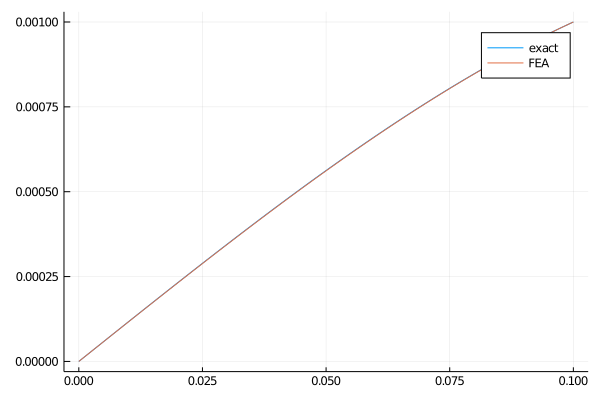

In [329]:
plot(node_loc, y, label = "exact")
plot!(node_loc,disp, label = "FEA")